In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap

**EDA**

In [117]:
df = pd.read_csv('data/suzuki_miyaura_data.csv')
df.replace('', np.NaN)
print(df.dtypes)
print(df.head())

reactant_1_smiles     object
reactant_2_smiles     object
catalyst_smiles       object
ligand_smiles         object
reagent_1_smiles      object
solvent_1_smiles      object
rxn                   object
yield                float64
dtype: object
                           reactant_1_smiles  \
0  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
1  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
2  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
3  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
4  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   

                   reactant_2_smiles       catalyst_smiles  \
0  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
1  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
2  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
3  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
4  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   

                             ligand_smiles reagent_1_smiles solvent_1_smiles  \
0           

In [15]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (5760, 8)
fraction of missing values in features:
ligand_smiles       0.083333
reagent_1_smiles    0.125000
dtype: float64
data types of the features with missing values:
ligand_smiles       object
reagent_1_smiles    object
dtype: object
fraction of points with missing values: 0.19791666666666666


count    5760.000000
mean        0.401095
std         0.280811
min         0.000000
25%         0.161946
50%         0.335762
75%         0.628715
max         1.000000
Name: yield, dtype: float64


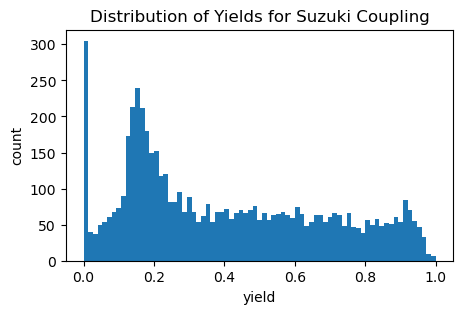

In [16]:
print(df['yield'].describe())

plt.figure(figsize=(5,3))

df['yield'].plot.hist(bins = int(np.sqrt(df.shape[0])) )  

#plt.semilogy()
plt.xlabel('yield')
plt.ylabel('count')
plt.title('Distribution of Yields for Suzuki Coupling')
plt.show()


reactant_1_smiles
C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                    1152
C1=C(Br)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                    1152
C1C2C(=NC=CC=2)C=CC=1OS(C(F)(F)F)(=O)=O.CCC1=CC(=CC=C1)CC    1152
C1=C(I)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                     1152
C1C(B(O)O)=CC=C2N=CC=CC=12.Cl.O                               384
[B-](C1=CC2=C(C=C1)N=CC=C2)(F)(F)F.[K+].O                     384
B1(OC(C(O1)(C)C)(C)C)C2=CC3=C(C=C2)N=CC=C3.O                  384
Name: count, dtype: int64


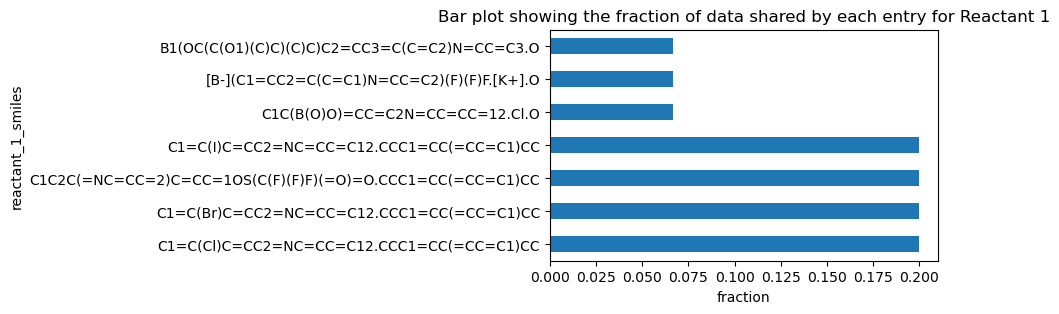

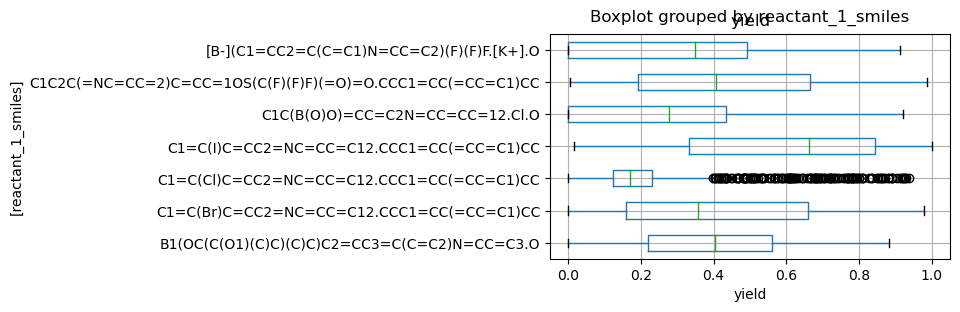

In [127]:
print(df['reactant_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reactant_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.title('Bar plot showing the fraction of data shared by each entry for Reactant 1')
plt.show()

df[['yield','reactant_1_smiles']].boxplot(by='reactant_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

reactant_2_smiles
CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O                  1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4    1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]       1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br                     1152
Name: count, dtype: int64


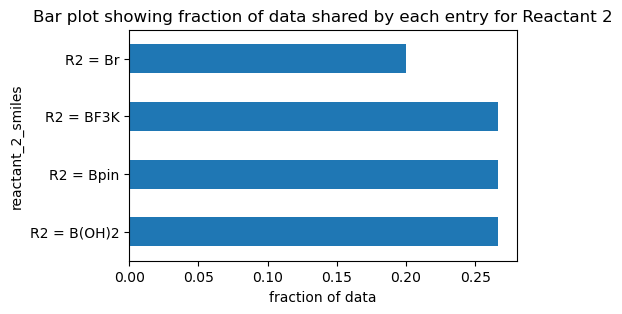

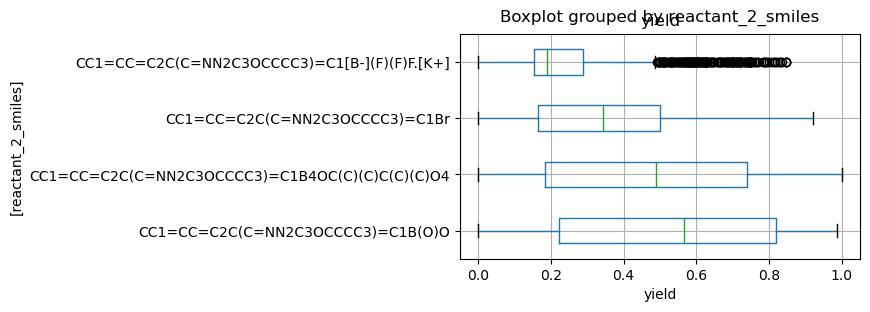

In [18]:
print(df['reactant_2_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reactant_2_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction of data')
plt.yticks([0,1,2,3],['R2 = B(OH)2', 'R2 = Bpin', 
                      'R2 = BF3K', 'R2 = Br'])
plt.title('Bar plot showing fraction of data shared by each entry for Reactant 2')
plt.show()

df[['yield','reactant_2_smiles']].boxplot(by='reactant_2_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

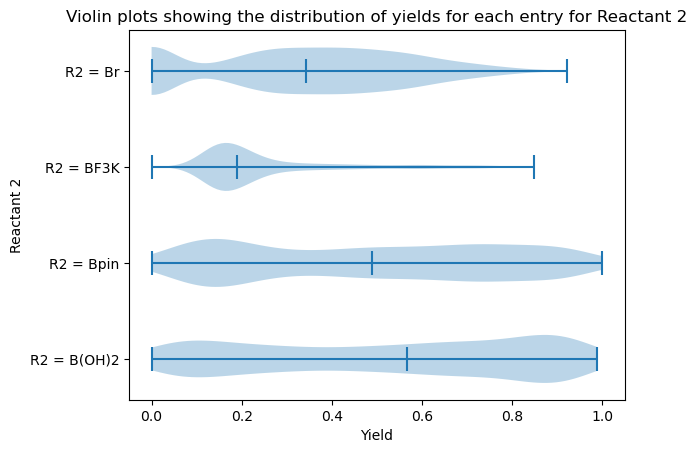

In [19]:
dataset = [df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br']['yield'].values]

#plt.figure(figsize=(5,3))

plt.violinplot(dataset = dataset, vert=False, showmedians=True)
plt.yticks([1,2,3,4],['R2 = B(OH)2', 'R2 = Bpin', 
                      'R2 = BF3K', 'R2 = Br'])
plt.ylabel('Reactant 2')
plt.xlabel('Yield')
plt.title('Violin plots showing the distribution of yields for each entry for Reactant 2')
plt.show()

reagent_1_smiles
[OH-].[Na+]                           720
[Na+].OC([O-])=O                      720
[F-].[Cs+]                            720
[K+].[K+].[K+].[O-]P([O-])([O-])=O    720
[K+].[OH-]                            720
[Li+].[O-]C(C)(C)C                    720
CCN(CC)CC                             720
Name: count, dtype: int64


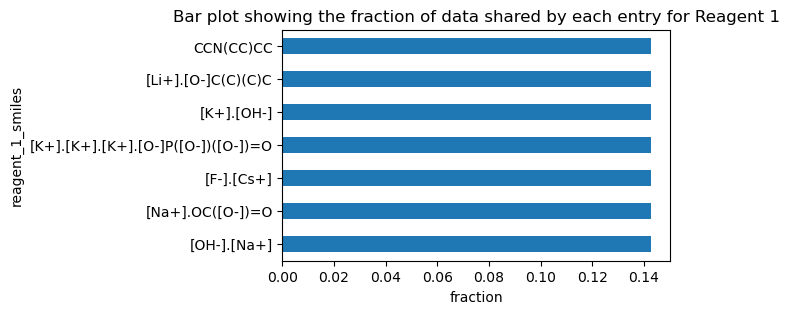

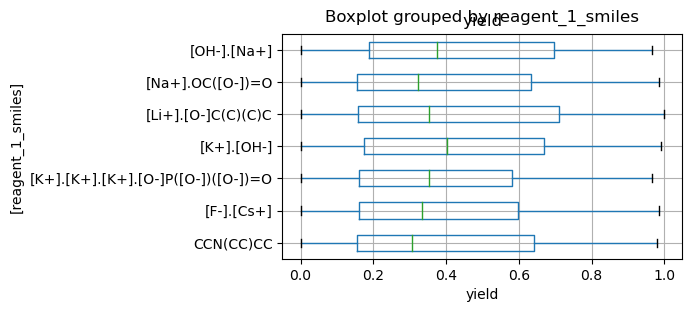

In [128]:
print(df['reagent_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reagent_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.title('Bar plot showing the fraction of data shared by each entry for Reagent 1')
plt.show()

df[['yield','reagent_1_smiles']].boxplot(by='reagent_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

ligand_smiles
CC(C)(C)P(C(C)(C)C)C(C)(C)C                                                               480
c3c(P(c1ccccc1)c2ccccc2)cccc3                                                             480
CC(C)(C)P(C1=CC=C(C=C1)N(C)C)C(C)(C)C                                                     480
C1(CCCCC1)P(C2CCCCC2)C3CCCCC3                                                             480
CC1=CC=CC=C1P(C2=CC=CC=C2C)C3=CC=CC=C3C                                                   480
CCCCP(C12CC3CC(C1)CC(C3)C2)C45CC6CC(C4)CC(C6)C5                                           480
COc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC                                                 480
CC(C)(C)P(C1=CC=C[CH]1)C(C)(C)C.CC(C)(C)P(C1=CC=C[CH]1)C(C)(C)C.[Fe]                      480
P(c2ccccc2c1c(cc(cc1C(C)C)C(C)C)C(C)C)(C3CCCCC3)C4CCCCC4                                  480
C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.[Fe+2]    480
O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4cc

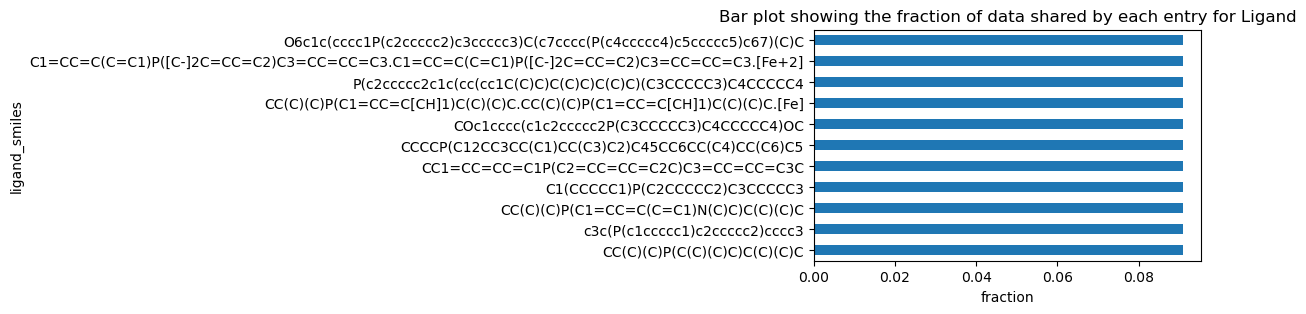

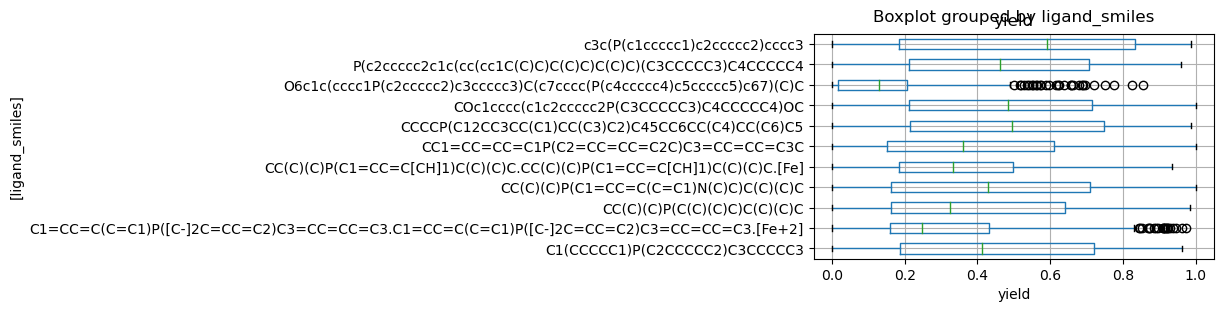

In [129]:
print(df['ligand_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['ligand_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.title('Bar plot showing the fraction of data shared by each entry for Ligand')
plt.show()

df[['yield','ligand_smiles']].boxplot(by='ligand_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

catalyst_smiles
CC(=O)O~CC(=O)O~[Pd]    5760
Name: count, dtype: int64


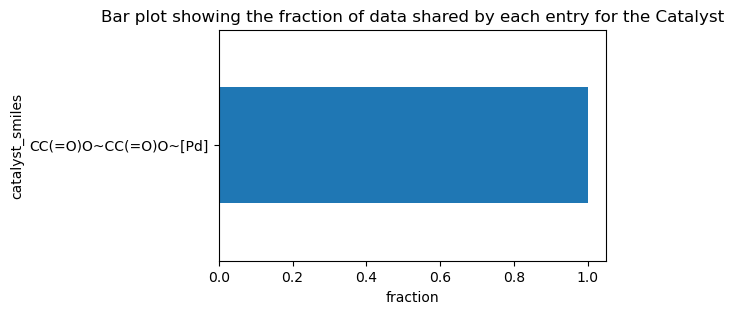

In [118]:
print(df['catalyst_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['catalyst_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.title('Bar plot showing the fraction of data shared by each entry for the Catalyst')
plt.show()

#same parent catalyst used for all reactions so we cn ignore this as a feature

solvent_1_smiles
CC#N.O        1440
C1CCOC1.O     1440
CN(C)C=O.O    1440
CO.O          1440
Name: count, dtype: int64


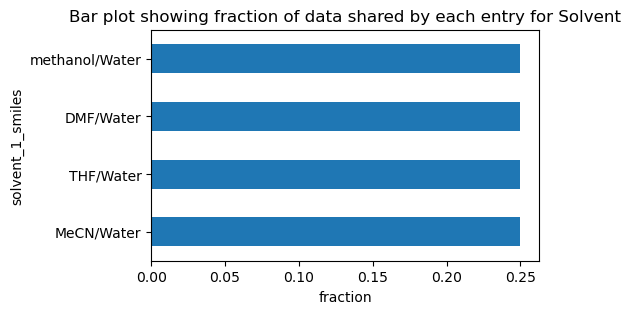

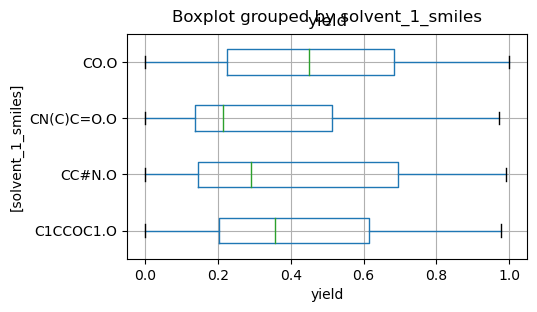

In [130]:
print(df['solvent_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['solvent_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.yticks([0,1,2,3],['MeCN/Water', 'THF/Water', 
                      'DMF/Water', 'methanol/Water'])
plt.title('Bar plot showing fraction of data shared by each entry for Solvent')
plt.show()

df[['yield','solvent_1_smiles']].boxplot(by='solvent_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

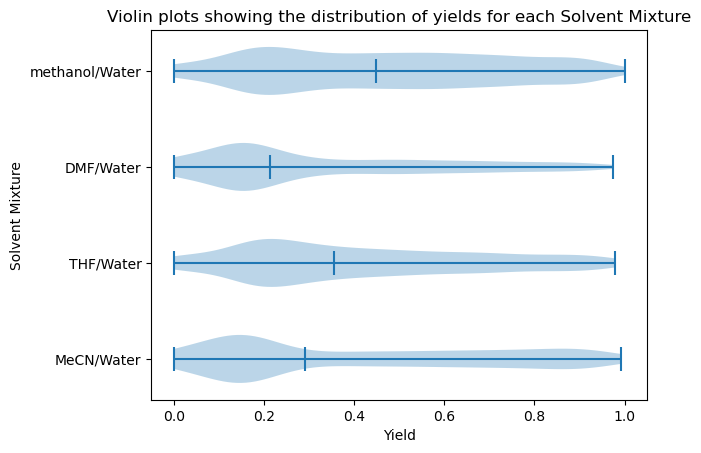

In [24]:
dataset = [df[df['solvent_1_smiles']=='CC#N.O']['yield'].values,
           df[df['solvent_1_smiles']=='C1CCOC1.O']['yield'].values,
           df[df['solvent_1_smiles']=='CN(C)C=O.O']['yield'].values,
           df[df['solvent_1_smiles']=='CO.O']['yield'].values]

#plt.figure(figsize=(5,3))

plt.violinplot(dataset = dataset, vert=False, showmedians=True)
plt.yticks([1,2,3,4],['MeCN/Water', 'THF/Water', 
                      'DMF/Water', 'methanol/Water'])
plt.ylabel('Solvent Mixture')
plt.xlabel('Yield')
plt.title('Violin plots showing the distribution of yields for each Solvent Mixture')
plt.show()

In [25]:
print(df['rxn'].value_counts())

#essentially a unique id for each combination of conditions for each reaction therefore we can drop this as a feature

rxn
CC#N.CC(=O)O~CC(=O)O~[Pd].CC(C)(C)P(C(C)(C)C)C(C)(C)C.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.Clc1ccc2ncccc2c1.O.[Na+].[OH-]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                               1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                 1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.Cc1ccccc1P(c1ccccc1C)c1ccccc1C.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                             1
Brc1ccc2ncccc2c1.C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                              1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c

**Splitting**

Dataset is only 5760 rows, so K-fold splitting will help get the most out of the data
Categorical data is fairly balanced, so no need to carry out stratified splitting

In [5]:
#Remove the features that provide no information
df = df.drop('rxn', axis=1)
df = df.drop('catalyst_smiles', axis=1)
y = df['yield']
X = df.loc[:, df.columns != 'yield']

In [6]:
#Regular train_test_split to see how the preprocessor performs

random_state =42

X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_other,y_other,test_size = 0.25,random_state=random_state)

(4608, 5) (4608,)
test set: (1152, 5) (1152,)


In [7]:
#build the preprocessing transformer - only have categorical features
cat_ftrs = ['reactant_1_smiles', 'reactant_2_smiles', 'ligand_smiles', 'reagent_1_smiles', 'solvent_1_smiles']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='None')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_ftrs)])

In [8]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print("Preprocessed training data dimensions: {}".format(df_train.shape))

#transform the validation set
df_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=df_val,columns = feature_names)
print("Preprocessed validation data dimensions: {}".format(df_val.shape))

#transform the test set
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print("Preprocessed test data dimensions: {}".format(df_test.shape))
print(feature_names)

Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
['cat__reactant_1_smiles_B1(OC(C(O1)(C)C)(C)C)C2=CC3=C(C=C2)N=CC=C3.O'
 'cat__reactant_1_smiles_C1=C(Br)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1=C(I)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1C(B(O)O)=CC=C2N=CC=CC=12.Cl.O'
 'cat__reactant_1_smiles_C1C2C(=NC=CC=2)C=CC=1OS(C(F)(F)F)(=O)=O.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_[B-](C1=CC2=C(C=C1)N=CC=C2)(F)(F)F.[K+].O'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]'
 'cat__ligand_smiles_C1(CCCCC1)P(C2CCCCC2)C3CCCCC3'
 'cat__ligand_smiles_C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC

**Midterm submission split and preprocess pipeline**

KFold splitting the validation and training data, and preprocessing within each individual fold.

In [9]:
kf = KFold(n_splits=4,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    print('Before preprocessing training set:',X_train.shape, y_train.shape) 
    print('Before preprocessing validation set:',X_val.shape, y_val.shape) 

    X_prep = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    print("Preprocessed training data dimensions: {}".format(df_train.shape))

    df_val = preprocessor.transform(X_val)
    df_val = pd.DataFrame(data=df_val,columns = feature_names)
    print("Preprocessed validation data dimensions: {}".format(df_val.shape))

    df_test = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    print("Preprocessed test data dimensions: {}".format(df_test.shape))    



Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data

**Evaluation Metric**

- Regression problem therefore should be using a regression metric
- Target value is a unitless float from 0 to 1. As the idea is to use the ML model to predict the success of the reaction, it is better to more heavily penalise larger errors as it is more costly to miss a very successful reaction or fruitlessly pursue an unsuccessful one due to a predictive error.
- Therefore, I will be using the Mean Squared Error metric (no need to root as the target is a unitless proportion).

**Baseline MSE**

In [10]:
random_state = 42

X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.75, random_state = random_state)

X_prep = preprocessor.fit_transform(X_train)

X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

In [32]:
random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

baseline_test_scores = np.zeros(len(random_states))

for i in range(len(random_states)):
    dummy_reg = DummyRegressor(strategy='mean')
    dummy_reg.fit(X_train_prep, y_train)
    baseline_test_scores[i] = mean_squared_error(y_test, dummy_reg.predict(X_test), squared=False)

print('Mean baseline test score:', np.mean(baseline_test_scores))

Mean baseline test score: 0.2842387098346775


In [33]:
test_means = []
test_stds = []
models = []
test_means.append(np.mean(baseline_test_scores))
test_stds.append(0)
models.append('Baseline')

**CV Pipeline**

In [ ]:
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
              #"max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0]) # ONLY THE ONE MODEL IS TRAINED HERE!
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

In [109]:
random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
final_models = []
test_scores = np.zeros(len(random_states))

# function for the ML pipeline
def MLpipe_KFold_MSE(X, y, preprocessor, ML_algo, param_grid):
    for i in range(len(random_states)):
        print('random state '+str(i))
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_states[i]) 
        kf = KFold(n_splits=4,shuffle=True,random_state=random_states[i])
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) 

        final_models.append(grid)

        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = mean_squared_error(y_test, y_test_pred, squared=False)
        print('test score:',test_scores[i])
    return test_scores, final_models

[Text(0.5, 1.0, 'Pearson Correlation Matrix for X_train')]

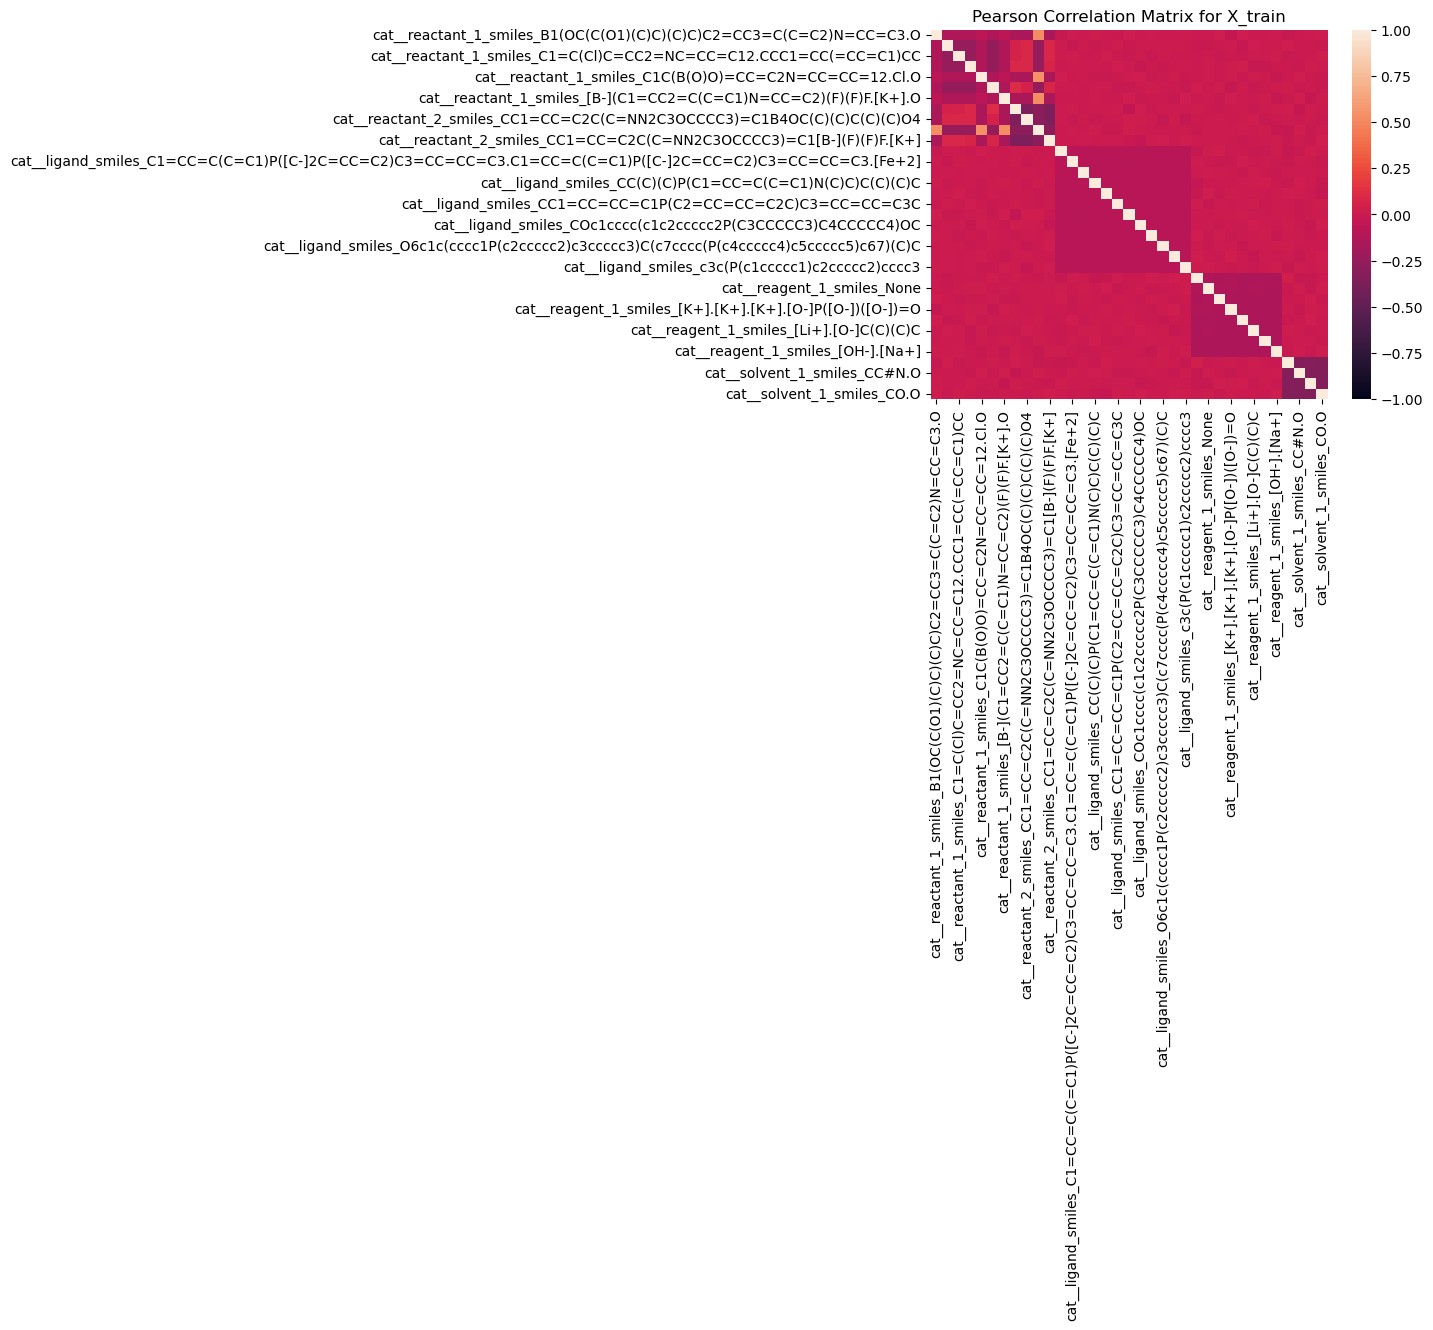

In [35]:
#Pearson correlation matrix to check preprocessed features for redundancy
corr = pd.DataFrame(X_train_prep, columns=preprocessor.get_feature_names_out()).corr()
sns.heatmap(corr, vmin=-1, vmax=1).set(title='Pearson Correlation Matrix for X_train')

#Find large square regions of slight negative correlation which is expected for variables where one category is picked from a set of categories.

**Linear Regression**

- Lasso
- Ridge
- Elastic Net

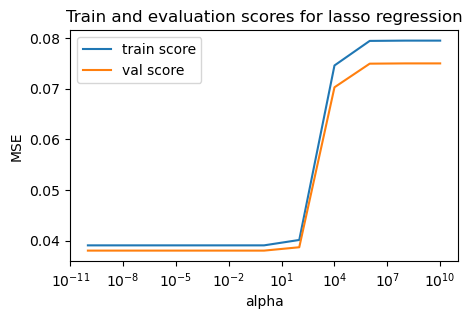

In [36]:
#Find the correct hyperparameter range for alpha
alpha = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]

train_MSE = np.zeros(len(alpha))
val_MSE = np.zeros(len(alpha))

for i in range(len(alpha)):
    lin_reg = Ridge(max_iter=100000, alpha = alpha[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(alpha,train_MSE,label='train score')
plt.plot(alpha,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for lasso regression')
plt.legend()
plt.show()

In [37]:
#Perform CV on lasso regression using the ideal hyperparameter range
lin_reg = Lasso(max_iter=100000)

param_grid = {
              'lasso__alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
              } 

lasso_test_scores, lasso_final_models = MLpipe_KFold_MSE(X, y, preprocessor, lin_reg, param_grid)

print('Mean test score:', np.mean(lasso_test_scores))
print('Standard deviation of test score:', np.std(lasso_test_scores))

random state 0
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'lasso__alpha': 0.01}
validation score: -0.04934737171109541
test score: 0.22472024732462154
random state 1
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'lasso__alpha': 0.01}
validation score: -0.049385402895926536
test score: 0.22358465613602196
random state 2
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'lasso__alpha': 0.01}
validation score: -0.0496002357487039
test score: 0.22561163778548507
random state 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'lasso__alpha': 0.01}
validation score: -0.049500281809697344
test score: 0.2238872013123902
random state 4
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'lasso__alpha': 0.01}
validation score: -0.04969047558005746
test score: 0.22001098925022425
random state 5
Fitting 4 folds for 

In [38]:
test_means.append(np.mean(lasso_test_scores))
test_stds.append(np.std(lasso_test_scores))
models.append('Lasso')

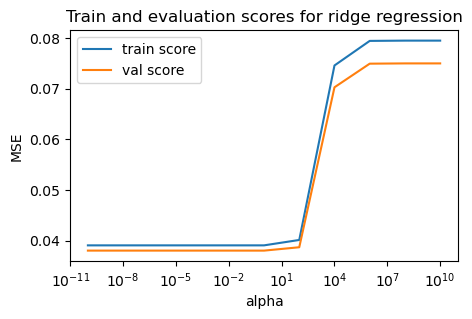

In [39]:
alpha = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]

train_MSE = np.zeros(len(alpha))
val_MSE = np.zeros(len(alpha))

for i in range(len(alpha)):
    lin_reg = Ridge(max_iter=100000, alpha = alpha[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(alpha,train_MSE,label='train score')
plt.plot(alpha,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for ridge regression')
plt.legend()
plt.show()

In [40]:
lin_reg = Ridge(max_iter=100000)

param_grid = {
              'ridge__alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
              } 

ridge_test_scores, ridge_final_models = MLpipe_KFold_MSE(X, y, preprocessor, lin_reg, param_grid)

print('Mean test score:', np.mean(ridge_test_scores))
print('Standard deviation of test score:', np.std(ridge_test_scores))

random state 0
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'ridge__alpha': 1.0}
validation score: -0.03950476037755998
test score: 0.19617865996909714
random state 1
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'ridge__alpha': 1.0}
validation score: -0.039505206376618925
test score: 0.1957958461052089
random state 2
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'ridge__alpha': 1.0}
validation score: -0.03933969549201757
test score: 0.19769192098216457
random state 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'ridge__alpha': 1.0}
validation score: -0.03932645214012309
test score: 0.19821735061782544
random state 4
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'ridge__alpha': 1.0}
validation score: -0.039180126054162545
test score: 0.1994787557086601
random state 5
Fitting 4 folds for each 

In [41]:
test_means.append(np.mean(ridge_test_scores))
test_stds.append(np.std(ridge_test_scores))
models.append('Ridge')

C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+01, tolerance: 2.747e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+01, tolerance: 2.747e-02
  model = cd_fast.enet_coordinate_descent(


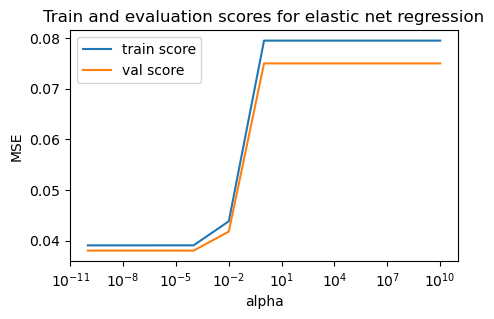

In [42]:
alpha = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]

train_MSE = np.zeros(len(alpha))
val_MSE = np.zeros(len(alpha))

for i in range(len(alpha)):
    lin_reg = ElasticNet(max_iter=100000, alpha = alpha[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(alpha,train_MSE,label='train score')
plt.plot(alpha,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for elastic net regression')
plt.legend()
plt.show()

In [43]:
lin_reg = ElasticNet(max_iter=100000)

param_grid = {
              'elasticnet__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
              'elasticnet__l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
              } 

enet_test_scores, enet_final_models = MLpipe_KFold_MSE(X, y, preprocessor, lin_reg, param_grid)

print('Mean test score:', np.mean(enet_test_scores))
print('Standard deviation of test score:', np.std(enet_test_scores))

random state 0
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.032e+01, tolerance: 3.629e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.0395039957918647
test score: 0.19620155934510572
random state 1
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.043e+01, tolerance: 3.629e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.03950373179946099
test score: 0.19586323608714845
random state 2
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.996e+01, tolerance: 3.604e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.03933793522235069
test score: 0.19770667854292462
random state 3
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.981e+01, tolerance: 3.606e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.039323753704403434
test score: 0.19822052563751108
random state 4
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.960e+01, tolerance: 3.660e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.0391783731611414
test score: 0.19942091727675199
random state 5
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.005e+01, tolerance: 3.629e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.039363550178355265
test score: 0.19738011550093482
random state 6
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.976e+01, tolerance: 3.609e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.03913985936666492
test score: 0.19874869597259184
random state 7
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.051e+01, tolerance: 3.630e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.03961406378013872
test score: 0.19513429266134022
random state 8
Fitting 4 folds for each of 42 candidates, totalling 168 fits


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.032e+01, tolerance: 3.632e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.0395877271278988
test score: 0.19614213107911133
random state 9
Fitting 4 folds for each of 42 candidates, totalling 168 fits
best model parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0}
validation score: -0.039016976944696365
test score: 0.19985065120518025
Mean test score: 0.19746688033086005
Standard deviation of test score: 0.001521358792211723


C:\Users\ste7m\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.958e+01, tolerance: 3.628e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [44]:
test_means.append(np.mean(enet_test_scores))
test_stds.append(np.std(enet_test_scores))
models.append('Elastic Net')

**Random Forest Regression**

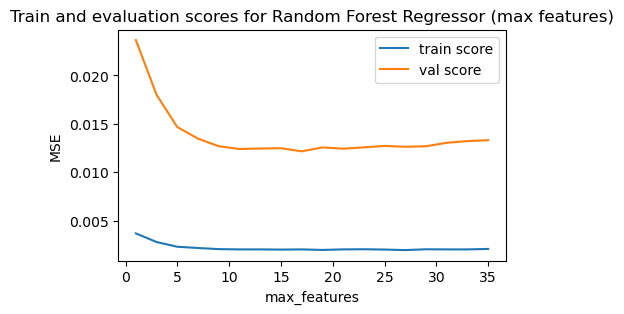

Optimal max_features for validation:  17
Optimal max_features for training:  27


In [45]:
#Checking the importance of optimising max_features
max_features = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]

train_MSE = np.zeros(len(max_features))
val_MSE = np.zeros(len(max_features))

for i in range(len(max_features)):
    lin_reg = RandomForestRegressor(n_estimators=100, max_depth=None, max_features = max_features[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(max_features,train_MSE,label='train score')
plt.plot(max_features,val_MSE,label='val score')
plt.xlabel('max_features')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for Random Forest Regressor (max features)')
plt.legend()
plt.show()

print("Optimal max_features for validation: ", max_features[np.argmin(val_MSE)])
print("Optimal max_features for training: ", max_features[np.argmin(train_MSE)])

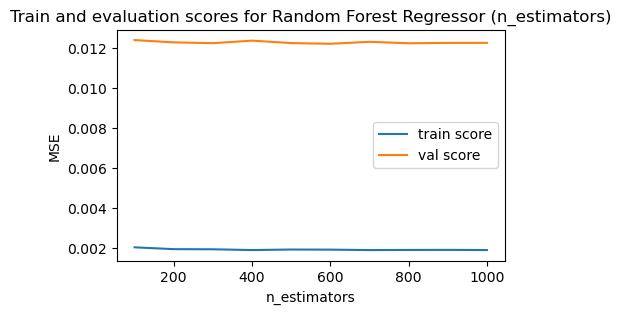

In [46]:
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

train_MSE = np.zeros(len(n_estimators))
val_MSE = np.zeros(len(n_estimators))

for i in range(len(n_estimators)):
    lin_reg = RandomForestRegressor(n_estimators=n_estimators[i], max_depth=None, max_features = 21)
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(n_estimators,train_MSE,label='train score')
plt.plot(n_estimators,val_MSE,label='val score')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for Random Forest Regressor (n_estimators)')
plt.legend()
plt.show()

In [47]:
reg = RandomForestRegressor(n_estimators=300)

param_grid = {
              'randomforestregressor__max_depth': [3, 5, 10, None], 
              'randomforestregressor__max_features': [1, 5, 10, 15, 20, 25, None]                                     
              } 

rf_test_scores, rf_final_models = MLpipe_KFold_MSE(X, y, preprocessor, reg, param_grid)

print('Mean test score:', np.mean(rf_test_scores))
print('Standard deviation of test score:', np.std(rf_test_scores))

random state 0
Fitting 4 folds for each of 28 candidates, totalling 112 fits
best model parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 20}
validation score: -0.012894901288134674
test score: 0.11179554551443797
random state 1
Fitting 4 folds for each of 28 candidates, totalling 112 fits
best model parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 20}
validation score: -0.013480391332251143
test score: 0.10616323875564575
random state 2
Fitting 4 folds for each of 28 candidates, totalling 112 fits
best model parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 20}
validation score: -0.013545687413989975
test score: 0.10977001057664997
random state 3
Fitting 4 folds for each of 28 candidates, totalling 112 fits
best model parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 20}
validation score: -0.013212925973441422


In [48]:
test_means.append(np.mean(rf_test_scores))
test_stds.append(np.std(rf_test_scores))
models.append('Random Forest')

**SVM Regression**

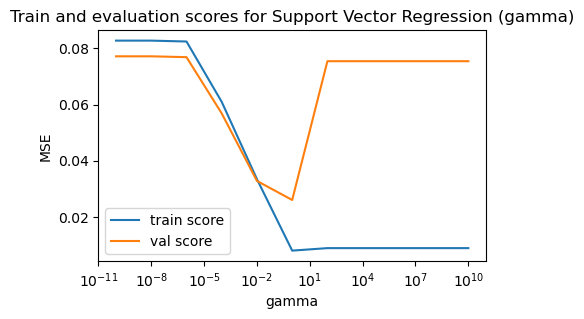

In [49]:
gamma = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]

train_MSE = np.zeros(len(gamma))
val_MSE = np.zeros(len(gamma))

for i in range(len(gamma)):
    lin_reg = SVR(C=1, gamma = gamma[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(gamma,train_MSE,label='train score')
plt.plot(gamma,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('gamma')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for Support Vector Regression (gamma)')
plt.legend()
plt.show()

In [50]:
print("Optimal gamma for validation: ", gamma[np.argmin(val_MSE)])
print("Optimal gamma for training: ", gamma[np.argmin(train_MSE)])

Optimal gamma for validation:  1.0
Optimal gamma for training:  1.0


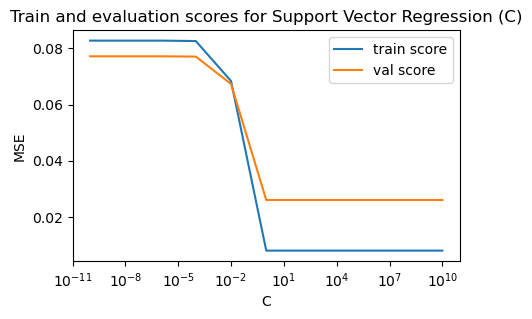

In [131]:
c = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]

train_MSE = np.zeros(len(c))
val_MSE = np.zeros(len(c))

for i in range(len(c)):
    lin_reg = SVR(gamma=1, C = c[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(c,train_MSE,label='train score')
plt.plot(c,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('C')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for Support Vector Regression (C)')
plt.legend()
plt.show()

In [52]:
print("Optimal C for validation: ", c[np.argmin(val_MSE)])
print("Optimal C for training: ", c[np.argmin(train_MSE)])

Optimal C for validation:  1.0
Optimal C for training:  1.0


In [53]:
reg = SVR()

param_grid = {
              'svr__gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2], 
              'svr__C': [1e-2, 1e-1, 1e0, 1e1, 1e2]                                   
              } 

svr_test_scores, svr_final_models = MLpipe_KFold_MSE(X, y, preprocessor, reg, param_grid)

print('Mean test score:', np.mean(svr_test_scores))
print('Standard deviation of test score:', np.std(svr_test_scores))

random state 0
Fitting 4 folds for each of 25 candidates, totalling 100 fits
best model parameters: {'svr__C': 10.0, 'svr__gamma': 0.1}
validation score: -0.015565605793729372
test score: 0.1182518681144847
random state 1
Fitting 4 folds for each of 25 candidates, totalling 100 fits
best model parameters: {'svr__C': 10.0, 'svr__gamma': 0.1}
validation score: -0.01620035439488058
test score: 0.11644694933683883
random state 2
Fitting 4 folds for each of 25 candidates, totalling 100 fits
best model parameters: {'svr__C': 10.0, 'svr__gamma': 0.1}
validation score: -0.01513649479461149
test score: 0.11947799630287653
random state 3
Fitting 4 folds for each of 25 candidates, totalling 100 fits
best model parameters: {'svr__C': 10.0, 'svr__gamma': 0.1}
validation score: -0.01555053776217175
test score: 0.11718523866864515
random state 4
Fitting 4 folds for each of 25 candidates, totalling 100 fits
best model parameters: {'svr__C': 10.0, 'svr__gamma': 0.1}
validation score: -0.015450224292033

In [81]:
test_means.append(np.mean(svr_test_scores))
test_stds.append(np.std(svr_test_scores))
models.append('Support Vector Machine')

**KNeighbors**

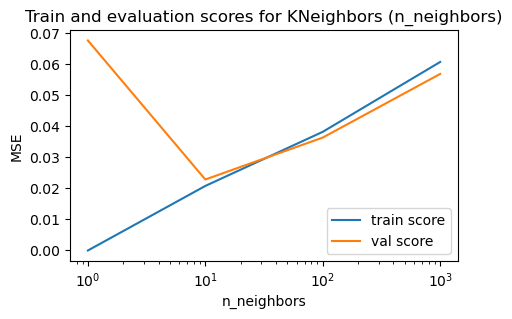

In [70]:
n_neighbors = [1, 10, 100, 1000]

train_MSE = np.zeros(len(n_neighbors))
val_MSE = np.zeros(len(n_neighbors))

for i in range(len(n_neighbors)):
    lin_reg = KNeighborsRegressor(n_neighbors = n_neighbors[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(n_neighbors,train_MSE,label='train score')
plt.plot(n_neighbors,val_MSE,label='val score')
plt.semilogx()
plt.xlabel('n_neighbors')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for KNeighbors (n_neighbors)')
plt.legend()
plt.show()

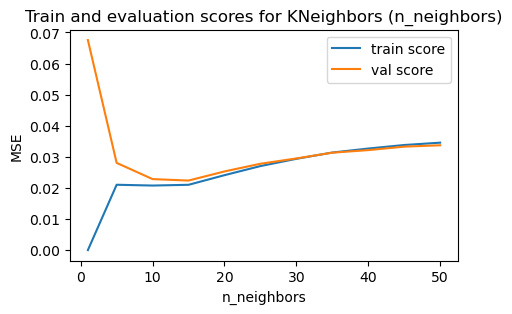

In [71]:
n_neighbors = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

train_MSE = np.zeros(len(n_neighbors))
val_MSE = np.zeros(len(n_neighbors))

for i in range(len(n_neighbors)):
    lin_reg = KNeighborsRegressor(n_neighbors = n_neighbors[i])
    lin_reg.fit(X_train_prep, y_train)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(X_train_prep))
    val_MSE[i] = mean_squared_error(y_val,lin_reg.predict(X_val_prep))  

plt.figure(figsize=(5,3))
plt.plot(n_neighbors,train_MSE,label='train score')
plt.plot(n_neighbors,val_MSE,label='val score')
plt.xlabel('n_neighbors')
plt.ylabel('MSE')
plt.title('Train and evaluation scores for KNeighbors (n_neighbors)')
plt.legend()
plt.show()

In [82]:
reg = KNeighborsRegressor()

param_grid = {
              'kneighborsregressor__n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21], 
              'kneighborsregressor__weights': ['uniform', 'distance'],
              'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski']
              } 

knr_test_scores, knr_final_models = MLpipe_KFold_MSE(X, y, preprocessor, reg, param_grid)

print('Mean test score:', np.mean(knr_test_scores))
print('Standard deviation of test score:', np.std(knr_test_scores))

random state 0
Fitting 4 folds for each of 54 candidates, totalling 216 fits
best model parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__weights': 'distance'}
validation score: -0.023154539452829463
test score: 0.1513700666626077
random state 1
Fitting 4 folds for each of 54 candidates, totalling 216 fits
best model parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__weights': 'distance'}
validation score: -0.023970707459428052
test score: 0.15286707537216832
random state 2
Fitting 4 folds for each of 54 candidates, totalling 216 fits
best model parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 13, 'kneighborsregressor__weights': 'distance'}
validation score: -0.022845442662663615
test score: 0.15338843512187603
random state 3
Fitting 4 folds for each of 54 candidates, totalling 216 fits
best model parameters

In [83]:
test_means.append(np.mean(knr_test_scores))
test_stds.append(np.std(knr_test_scores))
models.append('K-Neighbors')

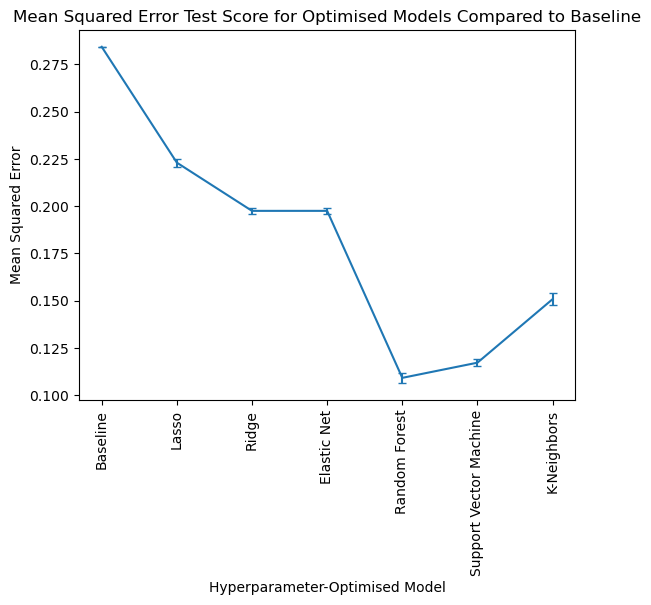

In [84]:
plt.errorbar(models, test_means, test_stds, capsize=3)
plt.ylabel('Mean Squared Error')
plt.xlabel('Hyperparameter-Optimised Model')
plt.xticks(rotation=90)
plt.title('Mean Squared Error Test Score for Optimised Models Compared to Baseline')
plt.show()

**Model Summary**

Overall, all models tested perform well, having lower MSE test scores than the baseline. The linear models perform less well than the non-linear models, with the optimal being the optimised Random Forest Regressor.

**Model Inspection**

Text(0.5, 1.0, 'True vs Predicted Yields using the Random Forest Model')

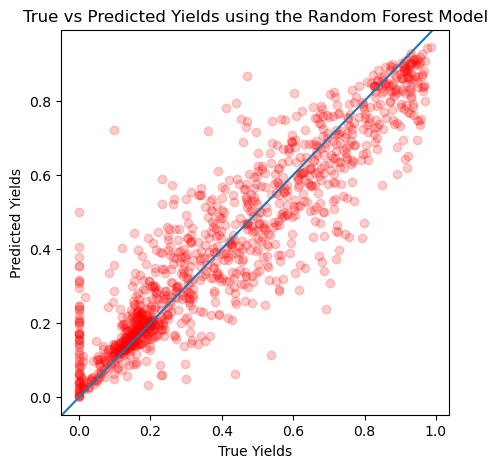

In [11]:
rf = RandomForestRegressor(n_estimators=300, max_depth=None, max_features = 20)
rf.fit(X_train_prep, y_train)

plt.figure(figsize=(5,5))
plt.scatter(y_test,rf.predict(X_test_prep),color='red', alpha=0.2)
plt.axline((0, 0), slope=1)
plt.xlabel('True Yields')
plt.ylabel('Predicted Yields')
plt.title('True vs Predicted Yields using the Random Forest Model')

**Model Interpretability - Mean Decrease in Impurity**

Text(0.5, 1.0, 'Feature Importance using MDI')

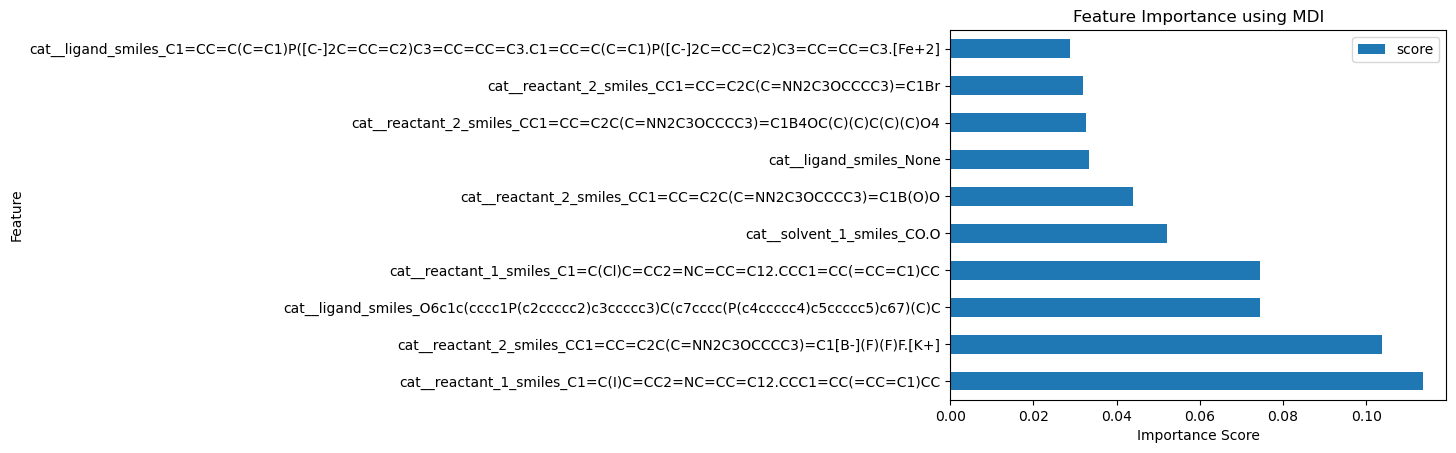

In [135]:
values = rf.feature_importances_
data = pd.DataFrame(data=values, index=preprocessor.get_feature_names_out(), 
                    columns=['score']).sort_values(by = 'score', ascending=False)
data.nlargest(10, columns='score').plot(kind='barh')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance using MDI')

**Model Interpretability - Permutation Importance**

Text(0.5, 1.0, 'Feature Importance using Permutation Importance')

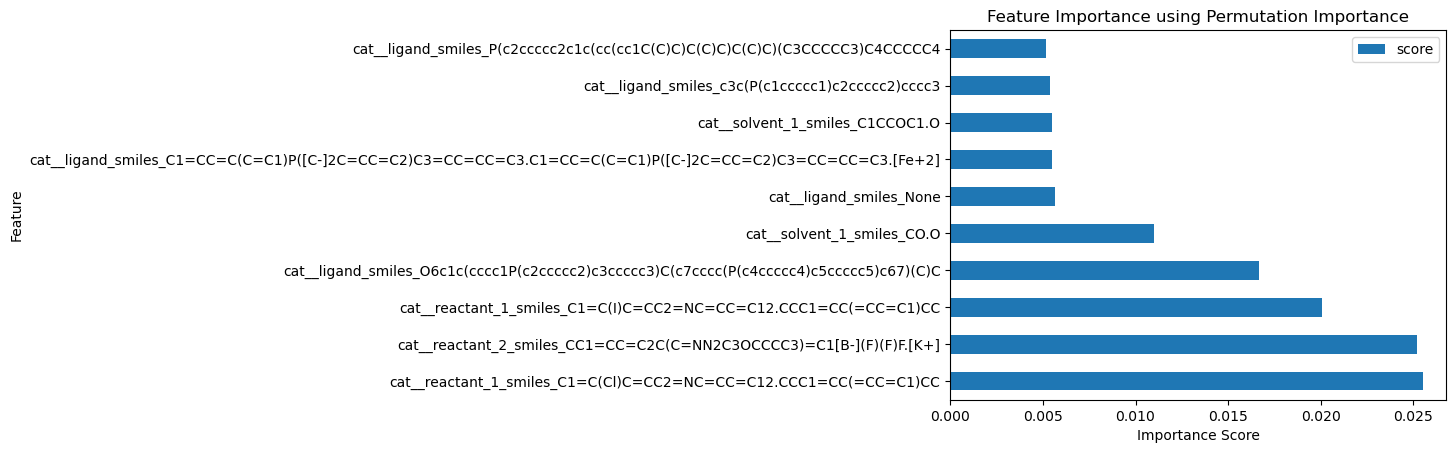

In [136]:
result = permutation_importance(rf, X_test_prep, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=42)
values = result.importances_mean
data = pd.DataFrame(data=values, index=preprocessor.get_feature_names_out(), columns=['score']).sort_values(by = 'score', ascending=False)
data.nlargest(10, columns='score').plot(kind='barh')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance using Permutation Importance')

**Model Interpretability - Global Shapley**

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


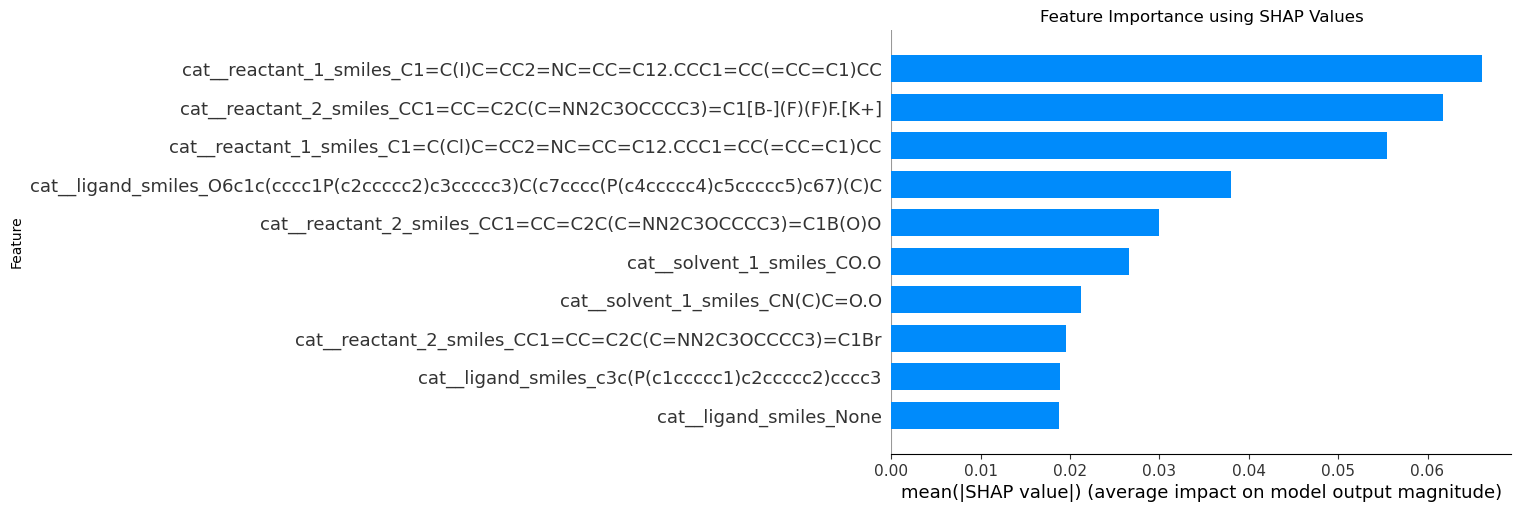

In [32]:
shap.initjs() 
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_test_prep)
shap.summary_plot(shap_values, features=preprocessor.get_feature_names_out(), plot_type='bar', max_display=10, show=False)
plt.ylabel('Feature')
plt.title('Feature Importance using SHAP Values')
plt.show()

**Model Interpretability - Local Shapley**

In [62]:
df_test = pd.DataFrame(data=X_test_prep,columns = preprocessor.get_feature_names_out())

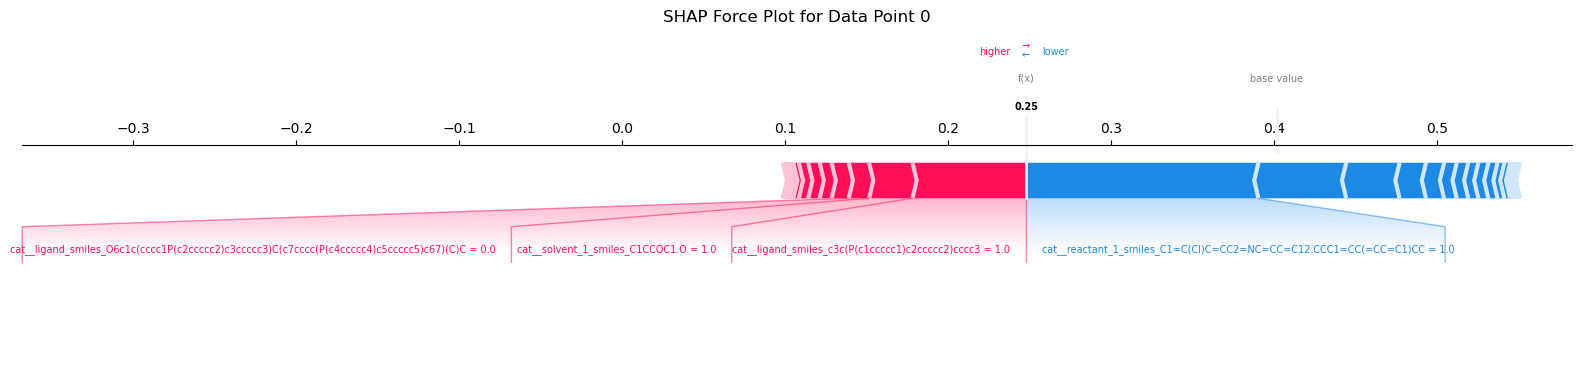

In [101]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df_test.iloc[0,:], matplotlib=1, show=0)
ax = plt.gca()
plt.title('SHAP Force Plot for Data Point 0', y=1.5)
for text in ax.texts:
    text.set_fontsize(7)   
plt.show()

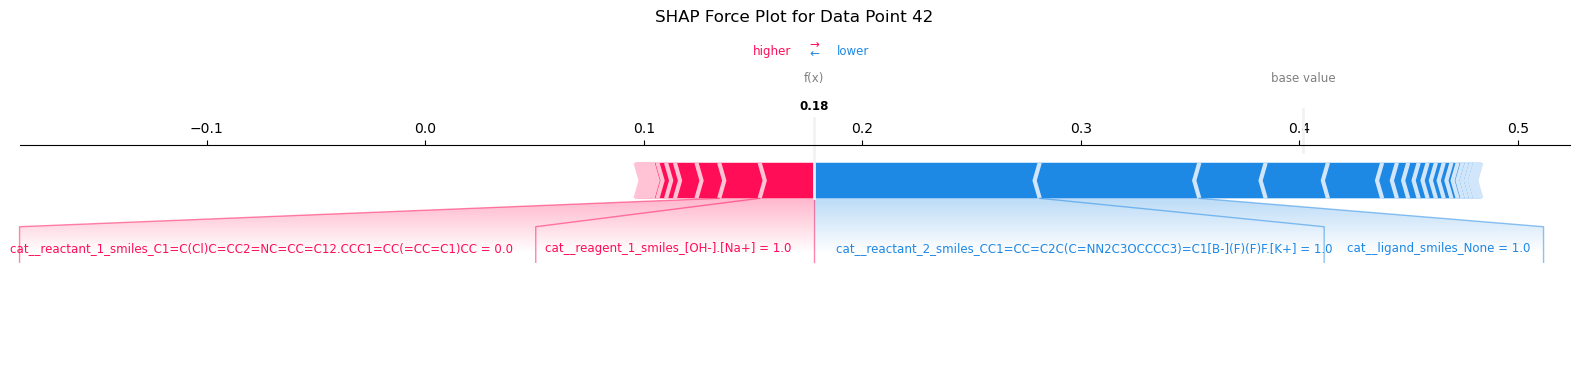

In [100]:
shap.force_plot(explainer.expected_value, shap_values[42,:], df_test.iloc[42,:], matplotlib=1, show=0)
ax = plt.gca()
plt.title('SHAP Force Plot for Data Point 42', y=1.5)
for text in ax.texts:
    text.set_fontsize(8.5)   
plt.show()

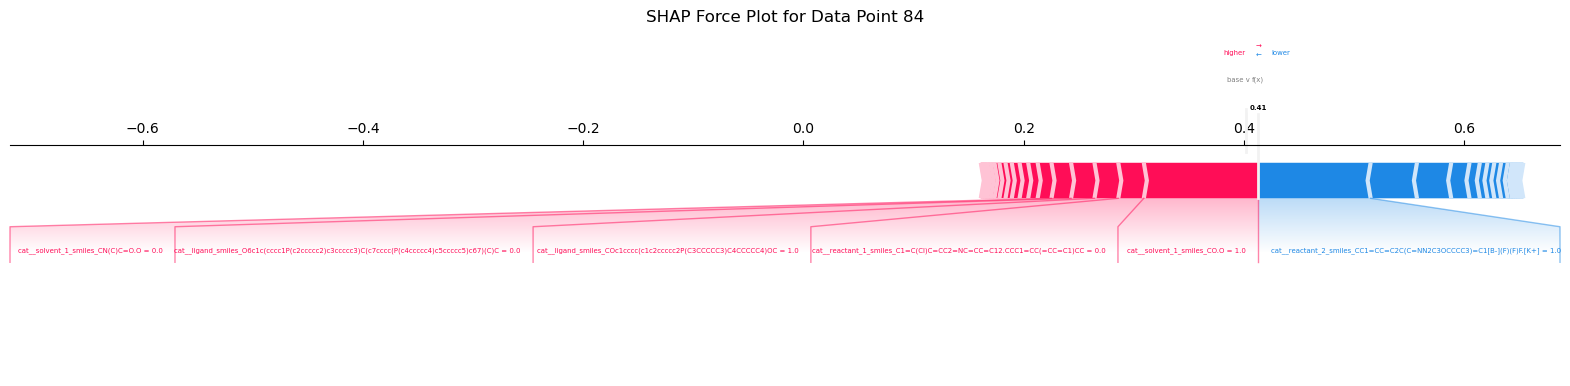

In [102]:
shap.force_plot(explainer.expected_value, shap_values[84,:], df_test.iloc[84,:], matplotlib=1, show=0)
ax = plt.gca()
plt.title('SHAP Force Plot for Data Point 84', y=1.5)
for text in ax.texts:
    text.set_fontsize(5)   
plt.show()

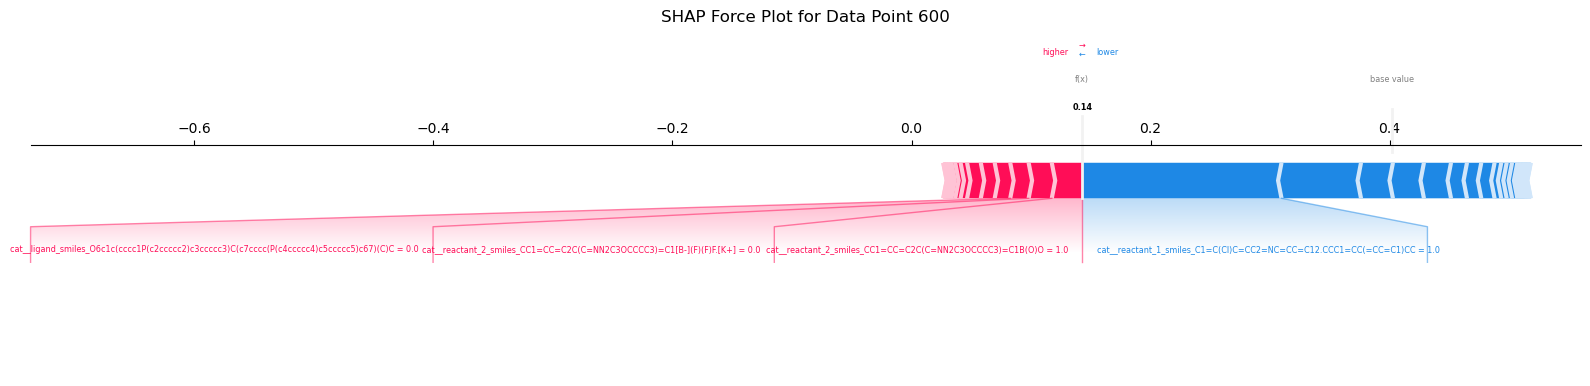

In [103]:
shap.force_plot(explainer.expected_value, shap_values[600,:], df_test.iloc[600,:], matplotlib=1, show=0)
ax = plt.gca()
plt.title('SHAP Force Plot for Data Point 600', y=1.5)
for text in ax.texts:
    text.set_fontsize(5.8)   
plt.show()

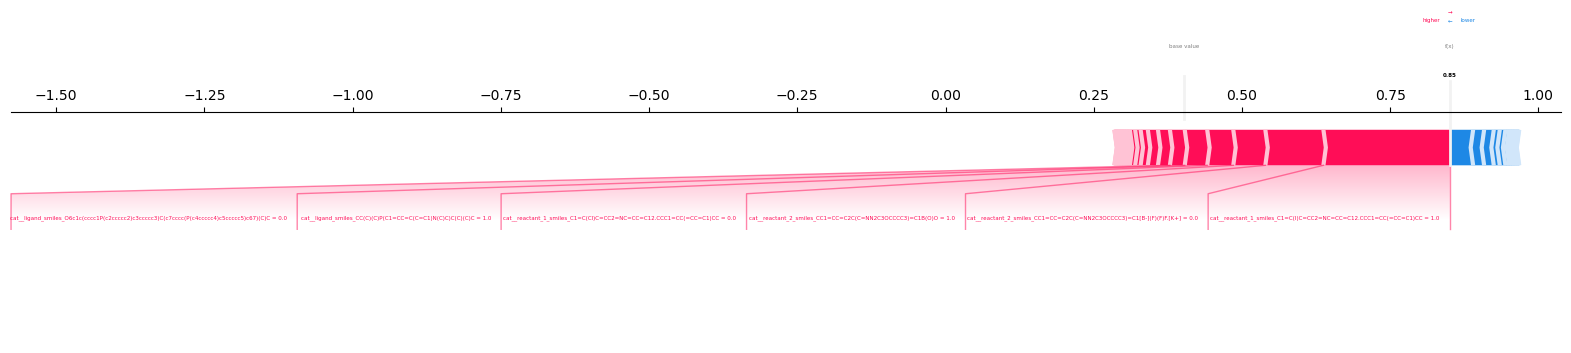

In [105]:
shap.force_plot(explainer.expected_value, shap_values[168,:], df_test.iloc[168,:], matplotlib=1, show=0)
ax = plt.gca()
for text in ax.texts:
    text.set_fontsize(4)   
plt.show()

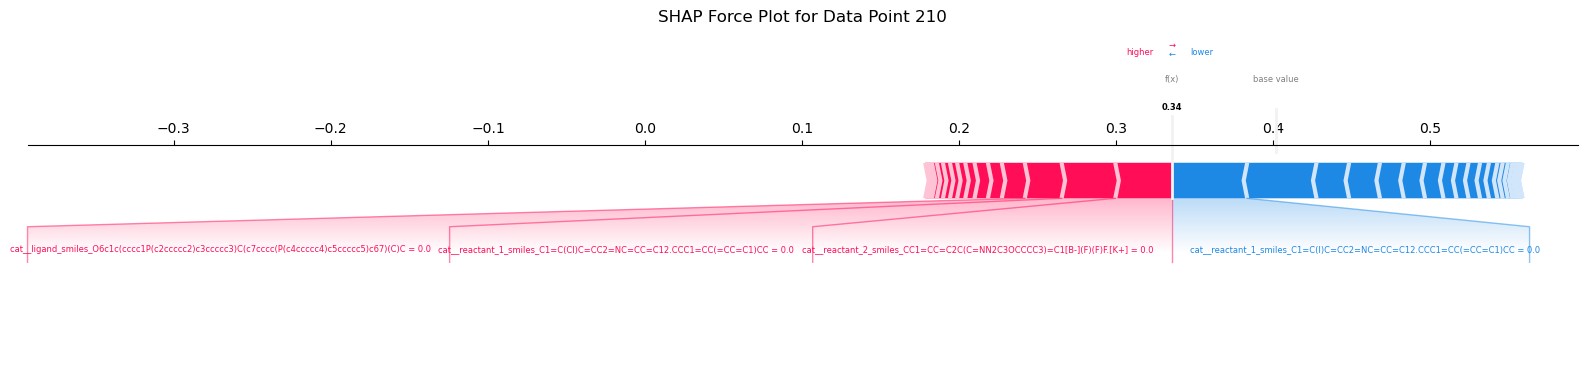

In [107]:
shap.force_plot(explainer.expected_value, shap_values[210,:], df_test.iloc[210,:], matplotlib=1, show=0)
ax = plt.gca()
plt.title('SHAP Force Plot for Data Point 210', y=1.5)
for text in ax.texts:
    text.set_fontsize(6)   
plt.show()